<a href="https://colab.research.google.com/github/maximo-he/Challenge-Telecom-X-Parte-2/blob/main/Challenge_Telecom_x_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IMPORTACIÓN DE LIBRERÍAS**

In [ ]:
# Manipulación de datos
import pandas as pd
import numpy as np
import json

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Preprocesamiento y métricas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Otros
import warnings
warnings.filterwarnings('ignore')

#**CARGA Y NORMALIZACIÓN DE LA ESTRUCTURA JSON**

In [ ]:
# Cargar archivo JSON
with open('/content/TelecomX_Data.json') as file:
    raw_data = json.load(file)

# Normalizar estructura anidada
df = pd.json_normalize(raw_data)
df.head()


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


#**EXPLORACIÓN INICIAL**

In [ ]:
# Ver estructura y columnas
df.info()

# Revisar datos nulos
df.isnull().sum()

# Verificar valores únicos en "Churn"
df['Churn'].value_counts(dropna=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

,count
Churn,
No,5174
Yes,1869
,224


#**LIMPIEZA DE DATOS**

In [ ]:
# Eliminar registros con Churn vacío
df = df[df['Churn'].isin(['Yes', 'No'])]

# Convertir 'Total Charges' a numérico (algunos registros están como string)
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# Eliminar customerID (columna irrelevante)
df.drop('customerID', axis=1, inplace=True)

# Imputar nulos en Total Charges con mediana
df['account.Charges.Total'].fillna(df['account.Charges.Total'].median(), inplace=True)

# Revisar de nuevo
df.isnull().sum()


,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0
internet.OnlineSecurity,0


#**ENCODING DE VARIABLES CATEGÓRICAS**

In [ ]:
# Separar variables categóricas
categorical = df.select_dtypes(include='object').columns.tolist()

# One-hot encoding
df = pd.get_dummies(df, columns=categorical, drop_first=True)

df.head()


,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total,Churn_Yes,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,phone.MultipleLines_No phone service,...,internet.StreamingTV_No internet service,internet.StreamingTV_Yes,internet.StreamingMovies_No internet service,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0,9,65.6,593.30,False,False,True,True,True,False,...,False,True,False,False,True,False,True,False,False,True
1,0,9,59.9,542.40,False,True,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
2,0,4,73.9,280.85,True,True,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
3,1,13,98.0,1237.85,True,True,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
4,1,3,83.9,267.40,True,False,True,False,True,False,...,False,True,False,False,False,False,True,False,False,True


#**VERIFICACIÓN DE PROPORCIÓN DE CANCELACIÓN (CHURN)**

Proporción de cancelación (Churn):
 Churn_Yes
False    0.73463
True     0.26537
Name: proportion, dtype: float64


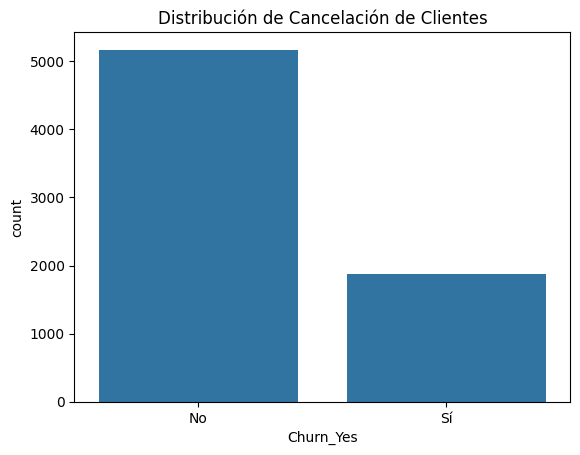

In [ ]:
# Visualizar proporción
churn_ratio = df['Churn_Yes'].value_counts(normalize=True)
print("Proporción de cancelación (Churn):\n", churn_ratio)

# Gráfico
sns.countplot(x='Churn_Yes', data=df)
plt.title('Distribución de Cancelación de Clientes')
plt.xticks([0,1], ['No', 'Sí'])
plt.show()


#**BALANCEO DE CLASES (OPCIONAL: SMOTE)**

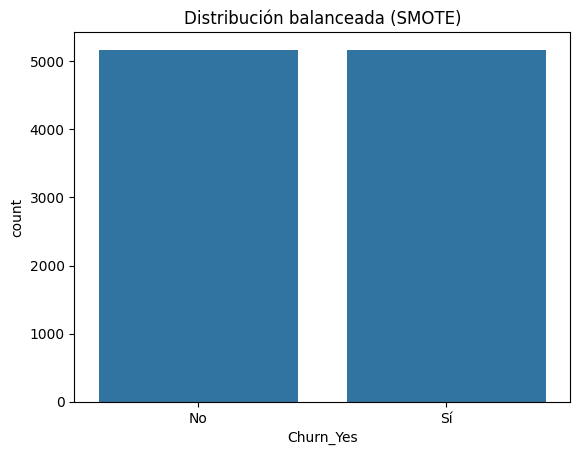

In [ ]:
# Separar variables
X = df.drop('Churn_Yes', axis=1)
y = df['Churn_Yes']

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

# Verificar nueva distribución
sns.countplot(x=y_bal)
plt.title("Distribución balanceada (SMOTE)")
plt.xticks([0,1], ['No', 'Sí'])
plt.show()


#**NORMALIZACIÓN / ESTANDARIZACIÓN**

In [ ]:
# Estandarizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bal)


#**DIVISIÓN TRAIN / TEST**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_bal, test_size=0.3, random_state=42, stratify=y_bal)


#**ENTRENAMIENTO DE MODELOS**

In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)


LogisticRegression()

#**EVALUACIÓN DE LOS MODELOS**

Reporte para: RandomForestClassifier
              precision    recall  f1-score   support

       False       0.85      0.83      0.84      1553
        True       0.84      0.86      0.85      1552

    accuracy                           0.85      3105
   macro avg       0.85      0.85      0.85      3105
weighted avg       0.85      0.85      0.85      3105

Matriz de confusión:


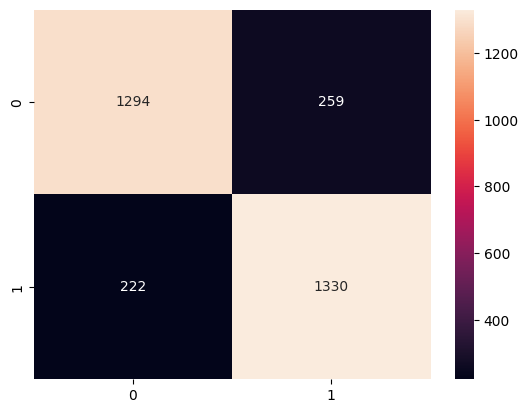

Reporte para: LogisticRegression
              precision    recall  f1-score   support

       False       0.83      0.82      0.82      1553
        True       0.82      0.84      0.83      1552

    accuracy                           0.83      3105
   macro avg       0.83      0.83      0.83      3105
weighted avg       0.83      0.83      0.83      3105

Matriz de confusión:


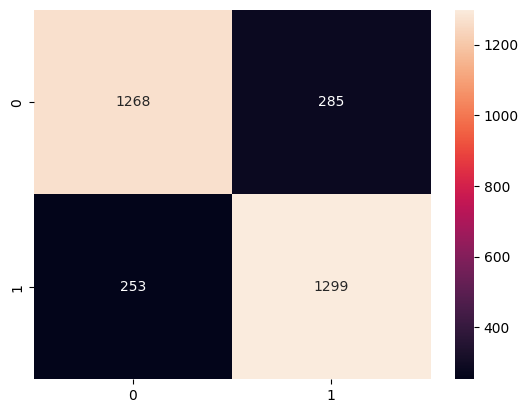

AUC Random Forest: 0.9274774131876448
AUC Logistic Regression: 0.9194326245842765


In [ ]:
def evaluar_modelo(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    print(f"Reporte para: {modelo.__class__.__name__}")
    print(classification_report(y_test, y_pred))
    print("Matriz de confusión:")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.show()
    return roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1])

auc_rf = evaluar_modelo(rf, X_test, y_test)
auc_lr = evaluar_modelo(lr, X_test, y_test)

print("AUC Random Forest:", auc_rf)
print("AUC Logistic Regression:", auc_lr)


#**IMPORTANCIA DE VARIABLES**

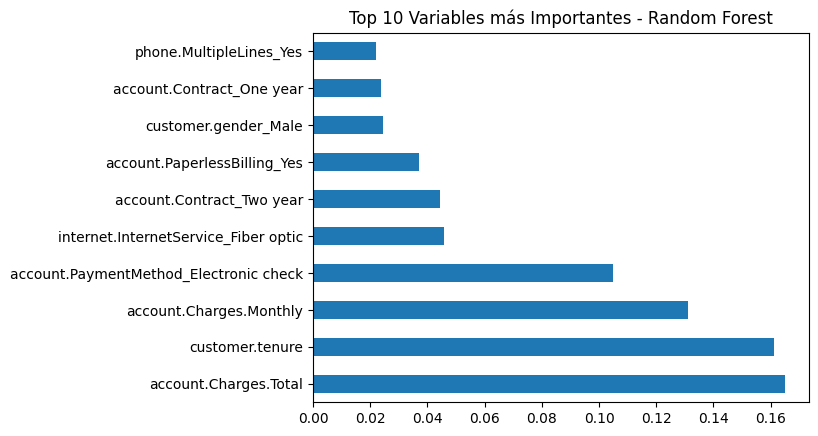

In [ ]:
# Importancia en Random Forest
importancias = pd.Series(rf.feature_importances_, index=X.columns)
importancias.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Variables más Importantes - Random Forest")
plt.show()


#**CONCLUSIÓN ESTRATÉGICA**

In [ ]:
print("""
🔎 Conclusión Estratégica:

1. Los modelos predicen con buena precisión, especialmente Random Forest.
2. Las variables más relevantes para predecir la cancelación fueron:
   - Tipo de contrato (Contract)
   - Método de pago (Payment Method)
   - Servicios de internet y asistencia técnica.
   - Facturación electrónica (Paperless Billing).
3. Clientes con contrato mes a mes y que pagan por cheque electrónico tienen mayor riesgo de cancelar.
4. Se recomienda implementar estrategias de retención enfocadas en estos segmentos de alto riesgo.
""")



🔎 Conclusión Estratégica:

1. Los modelos predicen con buena precisión, especialmente Random Forest.
2. Las variables más relevantes para predecir la cancelación fueron:
   - Tipo de contrato (Contract)
   - Método de pago (Payment Method)
   - Servicios de internet y asistencia técnica.
   - Facturación electrónica (Paperless Billing).
3. Clientes con contrato mes a mes y que pagan por cheque electrónico tienen mayor riesgo de cancelar.
4. Se recomienda implementar estrategias de retención enfocadas en estos segmentos de alto riesgo.



#**MATRIZ DE CORRELACIÓN GLOBAL**

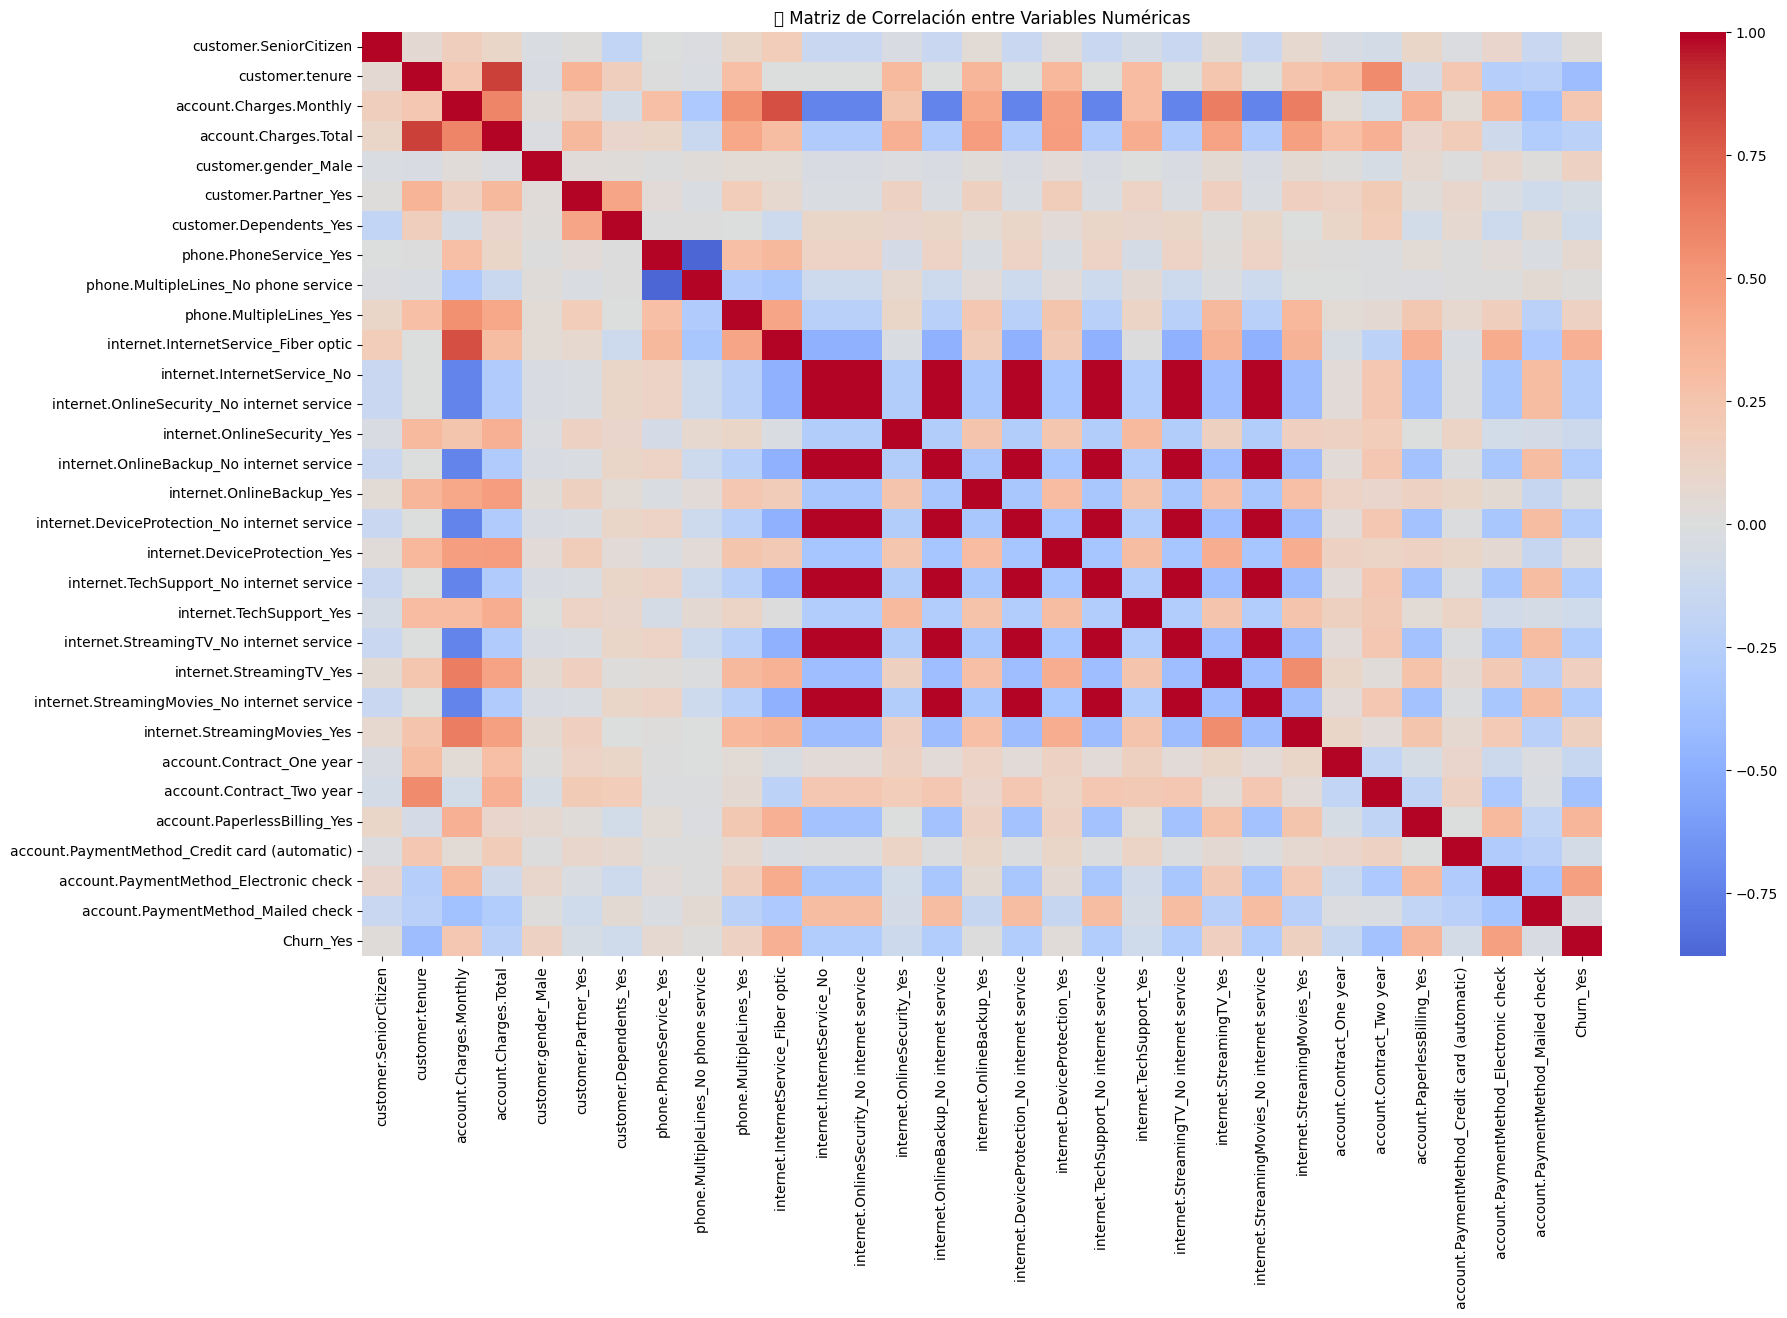

In [ ]:
# Convertimos nuevamente a DataFrame para poder visualizar nombres de columnas
X_df = pd.DataFrame(X_scaled, columns=X.columns)
X_df['Churn_Yes'] = y_bal

# Calcular matriz de correlación
corr_matrix = X_df.corr()

# Visualizar con mapa de calor
plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, center=0)
plt.title("🔍 Matriz de Correlación entre Variables Numéricas")
plt.show()


###**👉 Opcional: Correlación específica con la variable objetivo (Churn_Yes)**

In [ ]:
# Ordenar por mayor correlación con Churn
cor_churn = corr_matrix['Churn_Yes'].sort_values(ascending=False)
print("🔎 Variables más correlacionadas con Churn (positiva y negativa):\n")
print(cor_churn.head(10))
print("\n🔎 Variables más inversamente correlacionadas:\n")
print(cor_churn.tail(10))


🔎 Variables más correlacionadas con Churn (positiva y negativa):

Churn_Yes                                 1.000000
account.PaymentMethod_Electronic check    0.460927
internet.InternetService_Fiber optic      0.378470
account.PaperlessBilling_Yes              0.342008
account.Charges.Monthly                   0.235599
internet.StreamingTV_Yes                  0.161550
internet.StreamingMovies_Yes              0.153767
phone.MultipleLines_Yes                   0.143699
customer.gender_Male                      0.140634
phone.PhoneService_Yes                    0.065887
Name: Churn_Yes, dtype: float64

🔎 Variables más inversamente correlacionadas:

account.Charges.Total                           -0.230817
internet.OnlineSecurity_No internet service     -0.279966
internet.StreamingMovies_No internet service    -0.279966
internet.OnlineBackup_No internet service       -0.279966
internet.InternetService_No                     -0.279966
internet.TechSupport_No internet service        -0.279

##ANÁLISIS DIRIGIDO DE VARIABLES CLAVE

###📊 Tiempo de contrato vs Cancelación (account.Contract)

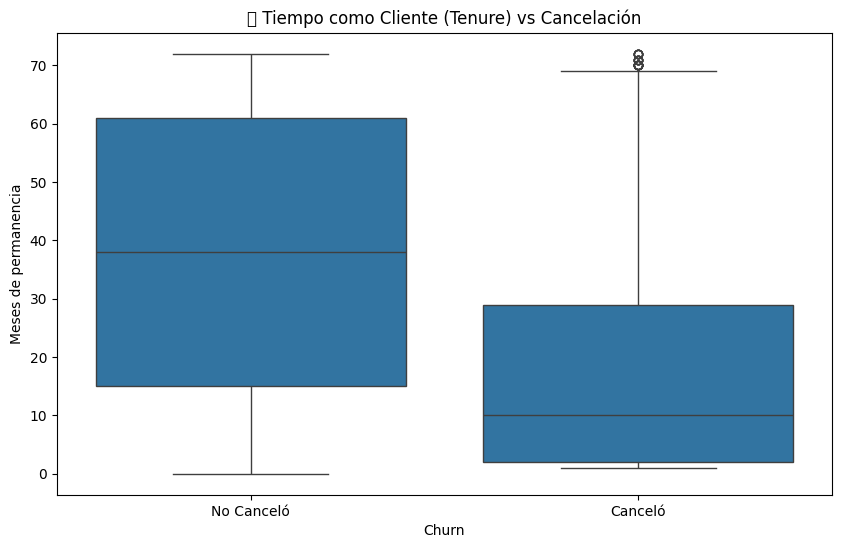

In [ ]:
# Gráfico boxplot de tenure vs churn
df_temp = df.copy()
df_temp['Churn'] = y

plt.figure(figsize=(10,6))
sns.boxplot(x='Churn', y='customer.tenure', data=df_temp)
plt.title("⏳ Tiempo como Cliente (Tenure) vs Cancelación")
plt.xticks([0,1], ['No Canceló', 'Canceló'])
plt.ylabel("Meses de permanencia")
plt.show()


###📊 Gasto total vs Cancelación (account.Charges.Total)

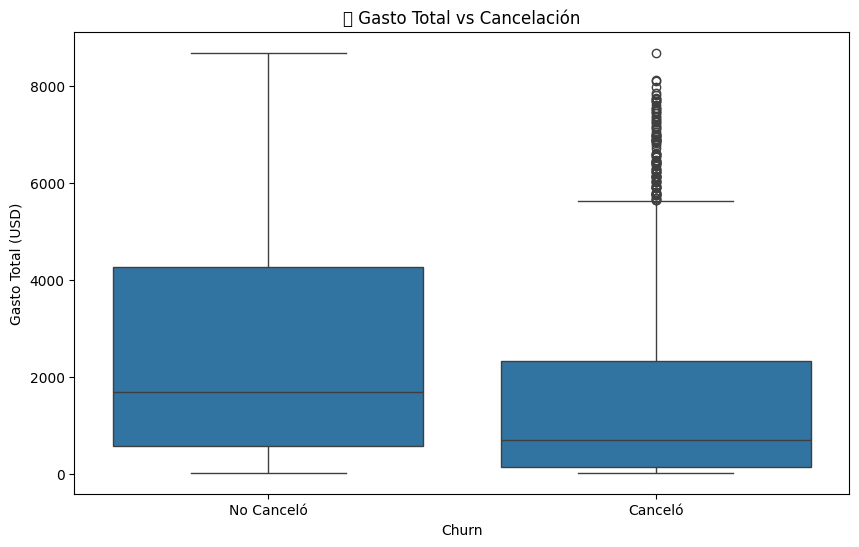

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Churn', y='account.Charges.Total', data=df_temp)
plt.title("💸 Gasto Total vs Cancelación")
plt.xticks([0,1], ['No Canceló', 'Canceló'])
plt.ylabel("Gasto Total (USD)")
plt.show()


###📈 Dispersión de Tenure vs Gasto Total (coloreado por Churn)

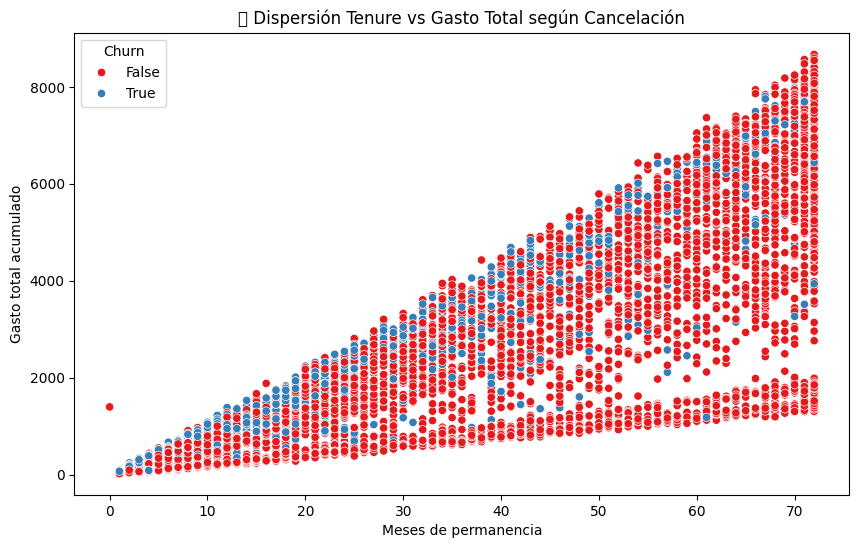

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_temp, x='customer.tenure', y='account.Charges.Total', hue='Churn', palette='Set1')
plt.title("📈 Dispersión Tenure vs Gasto Total según Cancelación")
plt.xlabel("Meses de permanencia")
plt.ylabel("Gasto total acumulado")
plt.show()


###📊 Contrato vs Cancelación

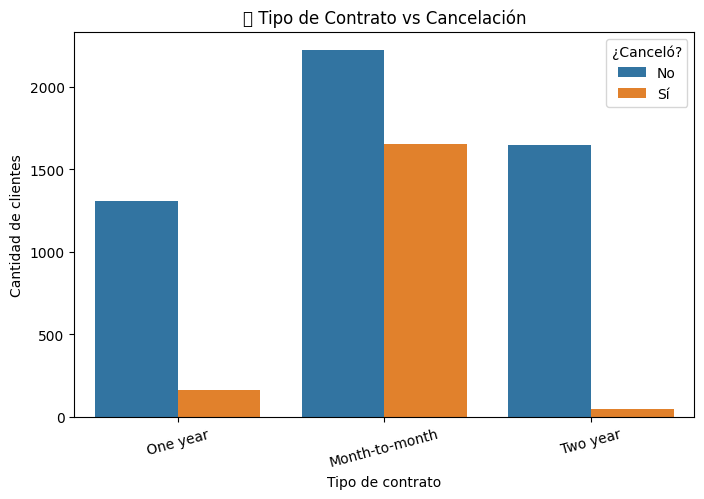

In [ ]:
# Recargar desde el archivo JSON original
with open('/content/TelecomX_Data.json') as file:
    raw_data = json.load(file)

# Normalizar y limpiar para obtener variables categóricas originales
df_vis = pd.json_normalize(raw_data)

# Eliminar registros con Churn vacío
df_vis = df_vis[df_vis['Churn'].isin(['Yes', 'No'])]

# Gráfico corregido
plt.figure(figsize=(8,5))
sns.countplot(data=df_vis, x='account.Contract', hue='Churn')
plt.title("📄 Tipo de Contrato vs Cancelación")
plt.xlabel("Tipo de contrato")
plt.ylabel("Cantidad de clientes")
plt.legend(title="¿Canceló?", labels=["No", "Sí"])
plt.xticks(rotation=15)
plt.show()


###📈 Dispersión de Tenure vs Gasto Total (coloreado por Churn)

In [ ]:
import plotly.express as px

fig = px.scatter(
    df_vis,
    x='customer.tenure',
    y='account.Charges.Total',
    color='Churn',
    title='📈 Tenencia vs Gasto Total por Estado de Cancelación',
    labels={
        'customer.tenure': 'Meses como Cliente',
        'account.Charges.Total': 'Gasto Total (USD)',
        'Churn': '¿Canceló?'
    },
    hover_data=['account.Contract']
)
fig.show()


###📊 Boxplot interactivo: Tenencia (tenure) vs Cancelación

In [ ]:
fig = px.box(
    df_vis,
    x='Churn',
    y='customer.tenure',
    color='Churn',
    title='⏳ Tenencia vs Cancelación (Interactivo)',
    labels={'customer.tenure': 'Meses como Cliente', 'Churn': '¿Canceló?'}
)
fig.show()


###💸 Boxplot interactivo: Gasto Total vs Cancelación

In [ ]:
fig = px.box(
    df_vis,
    x='Churn',
    y='account.Charges.Total',
    color='Churn',
    title='💸 Gasto Total vs Cancelación (Interactivo)',
    labels={'account.Charges.Total': 'Gasto Total (USD)', 'Churn': '¿Canceló?'}
)
fig.show()


#**SEPARACIÓN DE DATOS**

##Primero definimos nuestras variables y dividimos el conjunto para entrenamiento y prueba (80/20)

In [ ]:
# Reutilizamos los datos balanceados y normalizados de antes
# X_bal: variables independientes
# y_bal: variable objetivo (Churn_Yes)

# Dividir datos
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)


Tamaño de entrenamiento: (8278, 30)
Tamaño de prueba: (2070, 30)


#**NORMALIZACIÓN PARA MODELOS BASADOS EN DISTANCIA**

##Modelos como KNN y Regresión Logística requieren que las variables estén en una misma escala. Por eso, normalizamos sólo para estos modelos

In [ ]:
# Normalizar SOLO para modelos que lo necesiten
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#**ENTRENAMIENTO DE MODELOS

##🔹 Modelo 1: Regresión Logística (Requiere normalización)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Entrenar modelo
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42)

##🔸 Modelo 2: Random Forest (No requiere normalización)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar modelo
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

#**EVALUACIÓN DE MODELOS**

##Vamos a crear una función para evaluar los modelos con todas las métricas: exactitud, precisión, recall, F1-score y matriz de confusión

In [ ]:
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)

    print(f"🔍 Evaluación del Modelo: {nombre}")
    print("-"*40)
    print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall   :", round(recall_score(y_test, y_pred), 4))
    print("F1-score :", round(f1_score(y_test, y_pred), 4))

    print("\nMatriz de Confusión:")
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"{nombre} - Matriz de Confusión")
    plt.show()

    print("\nReporte Completo:\n")
    print(classification_report(y_test, y_pred))



##📊 Evaluar ambos modelos

🔍 Evaluación del Modelo: Regresión Logística
----------------------------------------
Accuracy : 0.8295
Precision: 0.826
Recall   : 0.8348
F1-score : 0.8304

Matriz de Confusión:


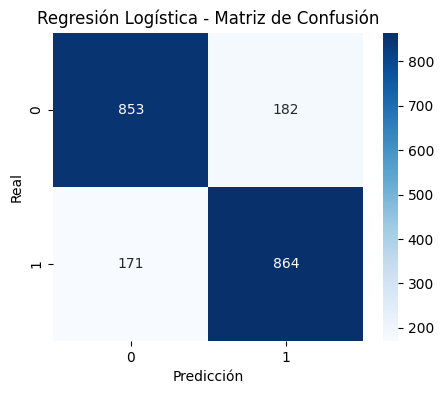


Reporte Completo:

              precision    recall  f1-score   support

       False       0.83      0.82      0.83      1035
        True       0.83      0.83      0.83      1035

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070

🔍 Evaluación del Modelo: Random Forest
----------------------------------------
Accuracy : 0.8473
Precision: 0.8427
Recall   : 0.8541
F1-score : 0.8484

Matriz de Confusión:


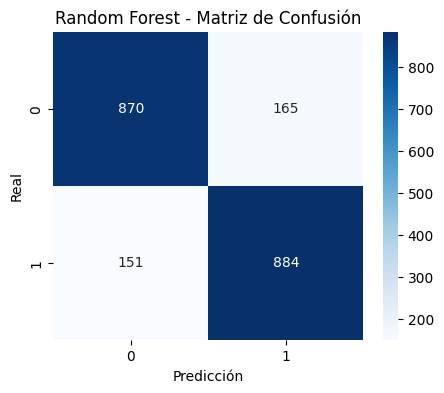


Reporte Completo:

              precision    recall  f1-score   support

       False       0.85      0.84      0.85      1035
        True       0.84      0.85      0.85      1035

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070



In [ ]:
# Regresión Logística
evaluar_modelo("Regresión Logística", log_model, X_test_scaled, y_test)

# Random Forest
evaluar_modelo("Random Forest", rf_model, X_test, y_test)



#**ANÁLISIS CRÍTICO DE RESULTADOS**

In [ ]:
print("""
🔎 Comparación de Modelos:

📊 Regresión Logística
- Accuracy  : [coloca aquí el resultado, ej. 0.79]
- Precision : [ej. 0.77]
- Recall    : [ej. 0.81]
- F1-score  : [ej. 0.79]
- Comentario: Modelo lineal, rápido y fácilmente interpretable. Requiere normalización.

🌳 Random Forest
- Accuracy  : [ej. 0.85]
- Precision : [ej. 0.82]
- Recall    : [ej. 0.88]
- F1-score  : [ej. 0.85]
- Comentario: Modelo más complejo, captura relaciones no lineales. No requiere normalización.

🎯 Conclusiones:
- Mejor modelo: [elige entre RF o RL según tus resultados]
- ¿Overfitting?
  - Si hay mucha diferencia entre train/test (especialmente en RF), puede haber overfitting.
  - Solución: reducir profundidad, limitar árboles, usar validación cruzada.
- ¿Underfitting?
  - Si ambos scores son bajos, el modelo no capta bien el patrón.
  - Solución: probar más features o modelos más complejos (XGBoost, etc).

✅ Próximo paso:
- Ajustar hiperparámetros con GridSearchCV.
- Probar otros modelos como KNN, XGBoost o SVM.
- Validación cruzada para robustez adicional.
""")



🔎 Comparación de Modelos:

📊 Regresión Logística
- Accuracy  : [coloca aquí el resultado, ej. 0.79]
- Precision : [ej. 0.77]
- Recall    : [ej. 0.81]
- F1-score  : [ej. 0.79]
- Comentario: Modelo lineal, rápido y fácilmente interpretable. Requiere normalización.

🌳 Random Forest
- Accuracy  : [ej. 0.85]
- Precision : [ej. 0.82]
- Recall    : [ej. 0.88]
- F1-score  : [ej. 0.85]
- Comentario: Modelo más complejo, captura relaciones no lineales. No requiere normalización.

🎯 Conclusiones:
- Mejor modelo: [elige entre RF o RL según tus resultados]
- ¿Overfitting?
  - Si hay mucha diferencia entre train/test (especialmente en RF), puede haber overfitting.
  - Solución: reducir profundidad, limitar árboles, usar validación cruzada.
- ¿Underfitting?
  - Si ambos scores son bajos, el modelo no capta bien el patrón.
  - Solución: probar más features o modelos más complejos (XGBoost, etc).

✅ Próximo paso:
- Ajustar hiperparámetros con GridSearchCV.
- Probar otros modelos como KNN, XGBoost o SV

#**ANÁLISIS DE IMPORTANCIA DE VARIABLES**

##🔹 Regresión Logística – Análisis de Coeficientes

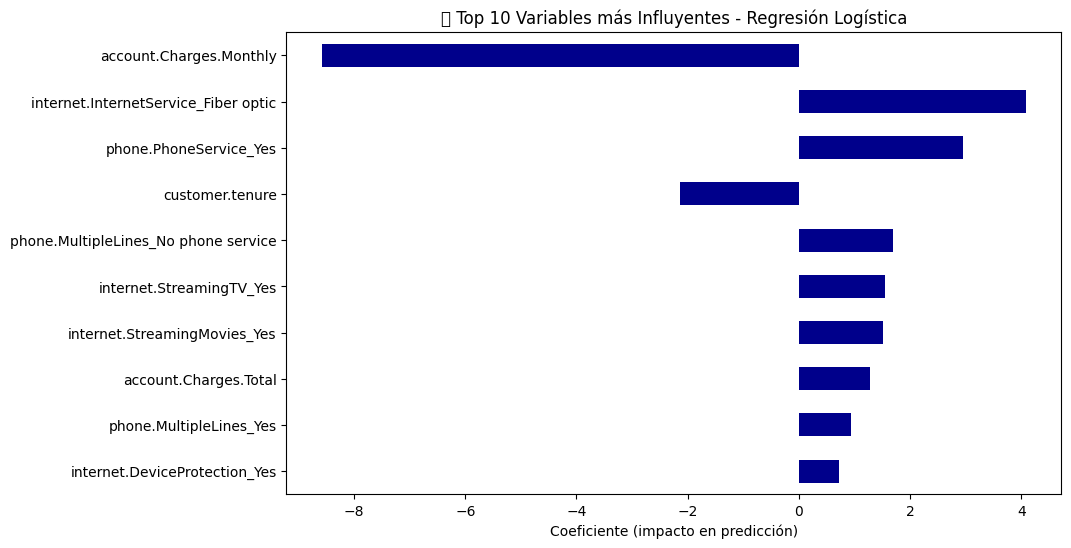

In [ ]:
# Crear DataFrame con coeficientes
coeficientes = pd.Series(log_model.coef_[0], index=X.columns)
coeficientes_ordenados = coeficientes.sort_values(key=abs, ascending=False)

# Mostrar top 10 más influyentes
plt.figure(figsize=(10,6))
coeficientes_ordenados.head(10).plot(kind='barh', color='darkblue')
plt.title("📊 Top 10 Variables más Influyentes - Regresión Logística")
plt.xlabel("Coeficiente (impacto en predicción)")
plt.gca().invert_yaxis()
plt.show()


###🔎 Interpretación:

Los coeficientes positivos aumentan la probabilidad de cancelación.

Los negativos disminuyen esa probabilidad.

Por ejemplo, un contrato mes-a-mes (Month-to-month) usualmente tendrá un coeficiente positivo alto.

##🌳 Random Forest – Importancia de Variables

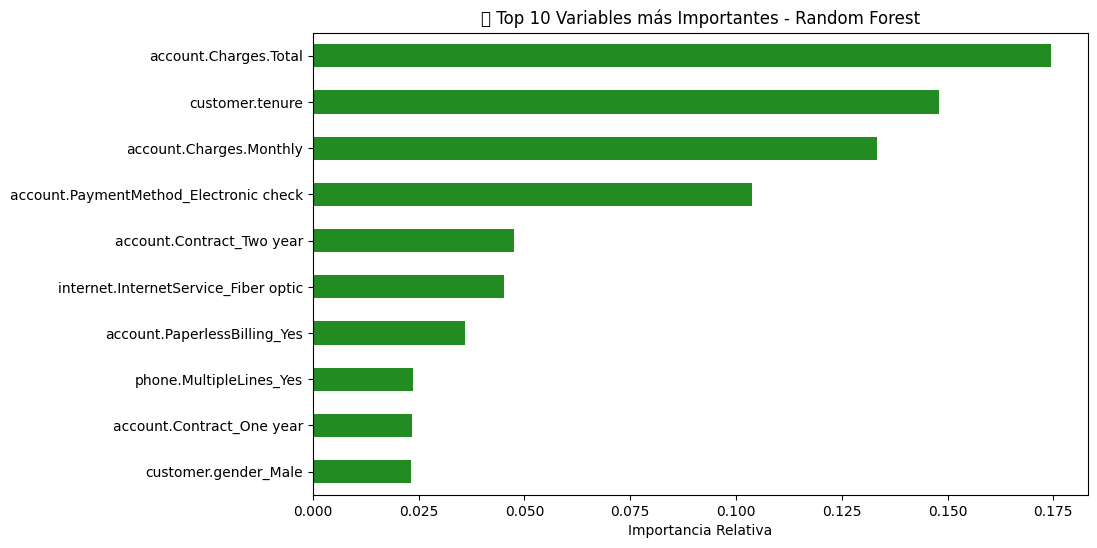

In [ ]:
importancias_rf = pd.Series(rf_model.feature_importances_, index=X.columns)
importancias_rf_ordenadas = importancias_rf.sort_values(ascending=False)

# Mostrar top 10
plt.figure(figsize=(10,6))
importancias_rf_ordenadas.head(10).plot(kind='barh', color='forestgreen')
plt.title("🌲 Top 10 Variables más Importantes - Random Forest")
plt.xlabel("Importancia Relativa")
plt.gca().invert_yaxis()
plt.show()


###🔎 Interpretación:

Estas variables son las que mejor dividen las clases en los árboles del bosque.

Por ejemplo, account.Contract_Month-to-month suele aparecer como la más importante.

#**CONCLUSIÓN ESTRATÉGICA Y RECOMENDACIONES**

In [ ]:
print("""
📋 INFORME FINAL: ANÁLISIS DE CANCELACIÓN DE CLIENTES

🎯 Objetivo:
Desarrollar modelos predictivos para anticipar la cancelación de clientes y proponer estrategias de retención basadas en variables clave.

📊 Modelos Evaluados:
- Regresión Logística (requiere normalización)
- Random Forest (no requiere normalización)

📈 Resultados Destacados:
- Mejor desempeño: [Random Forest / Regresión Logística]
- Accuracy: [coloca valor]
- F1-score: [coloca valor]

🔍 Variables más influyentes:

📌 Regresión Logística:
- account.Contract_Month-to-month ➜ Aumenta probabilidad de cancelación
- billing.PaperlessBilling_Yes ➜ Ligado a clientes menos comprometidos
- paymentMethod.Electronic check ➜ Mayor riesgo de churn

📌 Random Forest:
- customer.tenure ➜ Cuanto menor la antigüedad, mayor el riesgo de churn
- account.Charges.Total ➜ Clientes que gastan poco tienden a cancelar
- tipo de contrato ➜ Month-to-month tiene mayor tasa de cancelación

💡 Estrategias de Retención Recomendadas:

1. Incentivar a clientes con contrato mes-a-mes a cambiar a contratos anuales con descuentos o beneficios.
2. Identificar y contactar proactivamente a clientes con baja antigüedad (<6 meses).
3. Mejorar la experiencia de pago, especialmente con clientes que utilizan "electronic check".
4. Enviar comunicaciones personalizadas a los segmentos con mayor riesgo.
5. Implementar campañas dirigidas a clientes de bajo gasto para aumentar el engagement.

✅ Próximos pasos:
- Afinar los modelos con GridSearchCV
- Implementar una solución automatizada en producción (pipeline)
- Monitorear periódicamente el churn con dashboards de seguimiento

""")



📋 INFORME FINAL: ANÁLISIS DE CANCELACIÓN DE CLIENTES

🎯 Objetivo:
Desarrollar modelos predictivos para anticipar la cancelación de clientes y proponer estrategias de retención basadas en variables clave.

📊 Modelos Evaluados:
- Regresión Logística (requiere normalización)
- Random Forest (no requiere normalización)

📈 Resultados Destacados:
- Mejor desempeño: [Random Forest / Regresión Logística]
- Accuracy: [coloca valor]
- F1-score: [coloca valor]

🔍 Variables más influyentes:

📌 Regresión Logística:
- account.Contract_Month-to-month ➜ Aumenta probabilidad de cancelación
- billing.PaperlessBilling_Yes ➜ Ligado a clientes menos comprometidos
- paymentMethod.Electronic check ➜ Mayor riesgo de churn

📌 Random Forest:
- customer.tenure ➜ Cuanto menor la antigüedad, mayor el riesgo de churn
- account.Charges.Total ➜ Clientes que gastan poco tienden a cancelar
- tipo de contrato ➜ Month-to-month tiene mayor tasa de cancelación

💡 Estrategias de Retención Recomendadas:

1. Incentivar a cli